## Checking sentiment of my product NB 

### for sentiment classification task 

- 90% of Code are from T.Chack Respiratory

## What I added ?
- ### dataset
- `Stanford Sentiment Treebank` dataset was used and load with pytreebank library
- WITH simple line of code 


``` python
sst = pytreebank.load_sst()

get_set = lambda sst_lab:[(tree.label,tree.to_lines()[0]) for tree in sst_lab]

get_set_zoro_root = lambda sstlab : [(label,line )for tree in sstlab for label, line in tree.to_labeled_lines()]
```
we are able to load dataset and use this data with t Chack code

- the `get_set` function only use root nodes.
- Meanwhile, `get_set_zero_root` use all nodes.

- ### label pipeline

- In `label_pipeline = lambda x: int(x) - 1`, we change the pipeline to `label_pipeline = lambda x: int(x)` 

- ### Inference 
```python
def inference_classification(test_list,ret_sent= False,result = []):
    for sent in test_list:
        text_totorch = torch.tensor(text_pipeline(sent)).to(device).reshape(1, -1)
        text_length = torch.tensor([text_totorch.size(1)]).to(dtype=torch.int64)
        if ret_sent:
            result.append((sent,torch.max(model(text_totorch, text_length).squeeze(1).data, 1)[1].detach().cpu().numpy()))
        else:
            result.append(torch.max(model(text_totorch, text_length).squeeze(1).data, 1)[1].detach().cpu().numpy())
    return result
```

# Reference dataset

- Recursive Deep Models for Semantic Compositionality Over a Sentiment Treebank
Richard Socher, Alex Perelygin, Jean Wu, Jason Chuang, Christopher Manning, Andrew Ng and Christopher Potts
Conference on Empirical Methods in Natural Language Processing (EMNLP 2013)

In [10]:
import torch, torchdata, torchtext
from torch import nn

import time

#1. puffer - it's outdated....
#2. spend some money - 300 baht get collab pro

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#reproducibility 
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [11]:
torch.__version__

'1.13.1+cu117'

In [12]:
torchtext.__version__

'0.14.1'

In [13]:
torchdata.__version__

'0.5.1'

In [14]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [15]:
# TRY
GROUNDROOT = True


## 1. Load the dataset

Make our life easy by using some ready-to-be-used dataset by torchtext

- in your assignment, i will ask you to use penn treebank.....

In [16]:
import pytreebank
import torch
# from loguru import logger
from torch.utils.data import Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.vocab import FastText





In [17]:
sst = pytreebank.load_sst()

get_set = lambda sst_lab:[(tree.label,tree.to_lines()[0]) for tree in sst_lab]

get_set_zoro_root = lambda sstlab : [(label,line )for tree in sstlab for label, line in tree.to_labeled_lines()]



def ggt(get_set):
    train_s = get_set(sst['train'])
    dev_s = get_set(sst['dev'])
    test_s = get_set(sst['test'])
    return train_s,dev_s,test_s

if GROUNDROOT:
    train_s,dev_s,test_s = ggt(get_set_zoro_root)
else:
    train_s,dev_s,test_s = ggt(get_set)


# print(train_s[0])

fast_vectors = FastText(language='simple')
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)
vocab = build_vocab_from_iterator(yield_tokens(train_s), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])





In [18]:
train_size = len(list(iter(train_s)))
val_size   = len(list(iter(dev_s)))
test_size  = len(list(iter(test_s)))

In [19]:
train_size, val_size, test_size

(318582, 41447, 82600)

## 3. Preprocessing

In [20]:
next(iter(train_s))

(3,
 "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .")

In [21]:
vocab.set_default_index(vocab["<unk>"]) #if you don't the id of this word, set it unk

In [22]:
vocab(['Chaky', 'wants', 'his', 'student', 'to', 'be', 'number', '1', '.'])

[0, 919, 36, 2733, 9, 28, 908, 3233, 10]

In [23]:
id2word = vocab.get_itos()

In [24]:
id2word[0]

'<unk>'

In [25]:
vocab(['<pad>', '<bos>', '<eos>'])

[1, 2, 3]

In [26]:
len(vocab)  #52k unique words.....

17136

## 4. FastText embedding

We gonna insert this embedding to the NN on the fly.....

In [27]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

In [28]:
fast_embedding.shape #(vocab size, 300) == (52k, 300)

torch.Size([17136, 300])

In [29]:
#please lookup the fasttext embedding of id 100
fast_embedding[100][:10] #size of 300 dim of this word id 100

tensor([-0.0595, -0.0829,  0.0264, -0.2511, -0.0340,  0.2841,  0.1026, -0.0634,
         0.0880,  0.1869], device='cuda:0')

## 5. Preparing dataloader

Optional - you can either make your own batch loader....
You can use pytorch dataloader....

In [30]:
text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)   #1, 2, 3, 4 ---> 0, 1, 2, 3

In [31]:
'''
why padding????

in the same batch, e.g., batch size = 2

"chaky eat sushi", ==> "chaky", "eat", "sushi" ==> 0, 22, 11, 1, 1
"chaky sleep" ==> "chaky", "sleep" ==> 0, 99, 1, 1, 1

'''

'\nwhy padding????\n\nin the same batch, e.g., batch size = 2\n\n"chaky eat sushi", ==> "chaky", "eat", "sushi" ==> 0, 22, 11, 1, 1\n"chaky sleep" ==> "chaky", "sleep" ==> 0, 99, 1, 1, 1\n\n'

In [32]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #making each batch same length

pad_ix = vocab['<pad>']

#this function gonna be called by DataLoader
def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0)) #for padding
        
    return torch.tensor(label_list, dtype=torch.int64), \
        pad_sequence(text_list, padding_value=pad_ix, batch_first=True), \
        torch.tensor(length_list, dtype=torch.int64)

In [33]:
batch_size = 64

train_loader = DataLoader(train_s, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

val_loader   = DataLoader(dev_s, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

test_loader  = DataLoader(test_s, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)


In [34]:
for lab,text,l in train_loader:
    break
print(lab,'\n\n',text,'\n\n',l)

tensor([4, 2, 3, 2, 2, 3, 1, 4, 2, 4, 2, 0, 2, 2, 4, 3, 2, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 1, 2, 4, 2, 2, 2, 2, 4, 1, 2, 3, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2]) 

 tensor([[  163,     1,     1,  ...,     1,     1,     1],
        [   24,     1,     1,  ...,     1,     1,     1],
        [   16,  4723,     1,  ...,     1,     1,     1],
        ...,
        [  346,   797,     8,  ...,     1,     1,     1],
        [ 1344,     1,     1,  ...,     1,     1,     1],
        [    7, 14579,   594,  ...,     1,     1,     1]]) 

 tensor([ 1,  1,  2,  3,  1,  6,  1,  1,  1,  3,  1, 12,  5, 13,  5,  1,  1,  1,
         3,  1,  1, 11,  1,  1,  2,  1,  2,  1, 18,  2,  1,  1,  2, 18,  1,  9,
         2,  1, 15,  2,  3,  1,  1,  2,  4,  1,  1,  9, 26,  1,  1,  1,  1,  3,
         1,  1, 14,  1,  4,  5,  3,  4,  1,  6])


In [35]:
# for label, text, length in train_loader:
#     break

#label: [batch size, ]
#text : [batch size, longest length of this batch] ==> [batch size, seq len] ==> [b, l]
#length:[batch size, ]

# label, text, length  #why we need length --> we can later ignore padding....

## 6. Designing the model

In [36]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()
        #put padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_ix)
        self.lstm = nn.LSTM(emb_dim, 
                           hid_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hid_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        #text = [batch size, seq len]
        embedded = self.embedding(text)
        
        #++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
        
        #embedded = [batch size, seq len, embed dim]
        packed_output, (hn, cn) = self.lstm(packed_embedded)  #if no h0, all zeroes
        
        #++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        #output = [batch size, seq len, hidden dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        return self.fc(hn)

In [37]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [38]:
input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300         # Why 300, we do not know depend on you.
output_dim = 5 # [0, 1, 2, 3, 4] # We have 5 class

#for biLSTM
num_layers = 2
bidirectional = True
dropout = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [39]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy


def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text, text_length).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

# Function to calculate time.
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(val_loader)))
test_loader_length  = len(list(iter(test_loader)))


In [40]:
best_valid_loss = float('inf')
num_epochs      = 10
tolerance_counter = 0

save_path = f'{model.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        tolerance_counter = 0
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')   
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    # Tolerance techniques, stop the model if it start to overfit.
    if tolerance_counter >= 3:
        break

    tolerance_counter = tolerance_counter + 1

Epoch: 01 | Time: 0m 52s
	Train Loss: 0.484 | Train Acc: 80.52%
	 Val. Loss: 0.452 |  Val. Acc: 81.71%
Epoch: 02 | Time: 0m 52s
	Train Loss: 0.354 | Train Acc: 85.27%
	 Val. Loss: 0.457 |  Val. Acc: 80.39%
Epoch: 03 | Time: 0m 50s
	Train Loss: 0.313 | Train Acc: 86.89%
	 Val. Loss: 0.496 |  Val. Acc: 80.17%
Epoch: 04 | Time: 0m 49s
	Train Loss: 0.284 | Train Acc: 88.03%
	 Val. Loss: 0.499 |  Val. Acc: 79.85%


In [83]:
def inference_classification(test_list,ret_sent= False,result = []):
    for sent in test_list:
        text_totorch = torch.tensor(text_pipeline(sent)).to(device).reshape(1, -1)
        text_length = torch.tensor([text_totorch.size(1)]).to(dtype=torch.int64)
        if ret_sent:
            result.append((sent,torch.max(model(text_totorch, text_length).squeeze(1).data, 1)[1].detach().cpu().numpy()))
        else:
            result.append(torch.max(model(text_totorch, text_length).squeeze(1).data, 1)[1].detach().cpu().numpy())
    return result

In [86]:

test_case = ['The movie should have been good',
    'What a waste of space, why are this trash even here',
    "Ahoy, this fantastic movie all time" 
    ] 

print(inference_classification(test_case,True))

[('The movie should have been good', array([3])), ('What a waste of space, why are this trash even here', array([0])), ('Ahoy, this fantastic movie all time', array([4])), ('This software is really good', array([3])), ('The movie should have been good', array([3])), ('What a waste of space, why are this trash even here', array([0])), ('Ahoy, this fantastic movie all time', array([4]))]


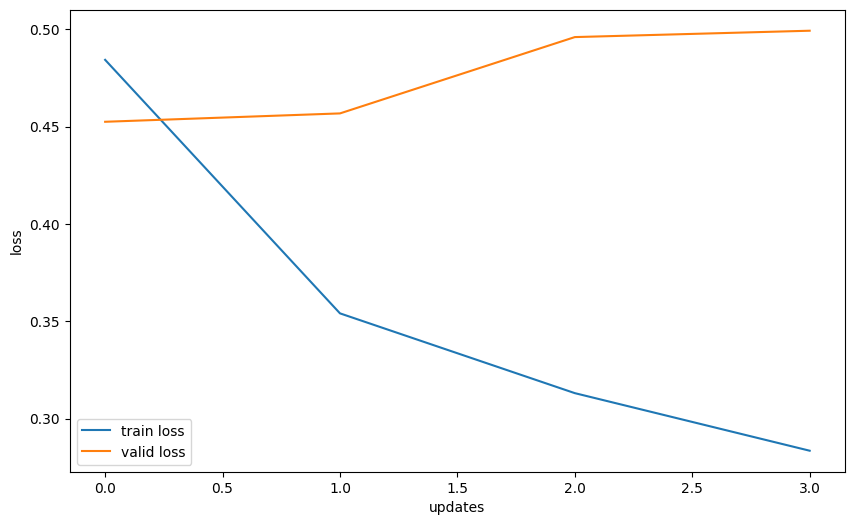

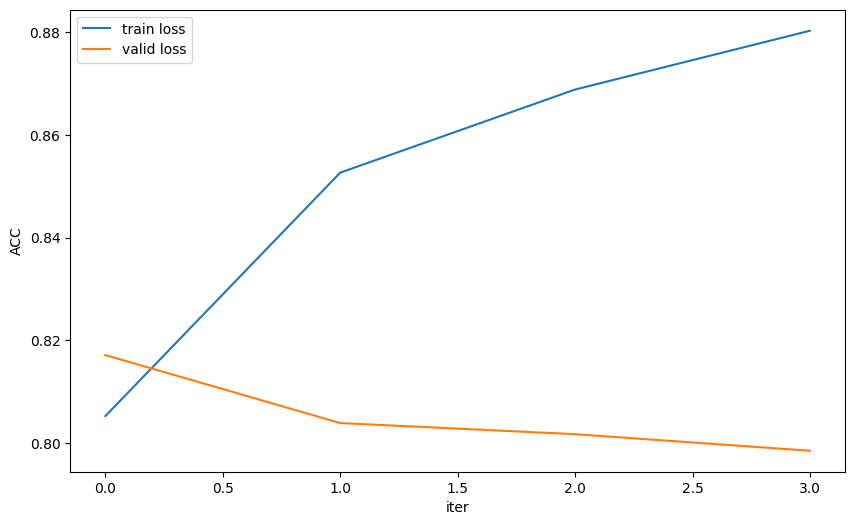

In [87]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')
plt.show()


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train loss')
ax.plot(valid_accs, label = 'valid loss')
plt.legend()
ax.set_xlabel('iter')
ax.set_ylabel('ACC')
plt.show()

In [57]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.458 | Test Acc: 81.64%
